In [1]:
import sys
import csv
import os
import pandas as pd
import numpy as np
import decimal
from pyneuroml import pynml
from pyneuroml.pynml import print_comment_v
from pyneuroml.lems import LEMSSimulation
import neuroml as nml
import neuroml.writers as writers
import random
import numpy
import eden_tools
from icecream import ic
dir(eden_tools)
os.getcwd()
from IPython.display import clear_output
random.seed(12345)
def fix_measured(measured):
    meas_out = []
    for trace in measured:
        if trace == 'v':
            addend = 'v'
        elif trace == 'caConc':
            addend = 'caConc'
        elif trace == 'm':
            addend = 'biophys/membraneProperties/na_s_soma/na_s/m/q'
        elif trace == 'h':
            addend = 'biophys/membraneProperties/na_s_soma/na_s/h/q'
        elif trace == 'n':
            addend = 'biophys/membraneProperties/kdr_soma/kdr/n/q'
        elif trace == 'x':
            addend = 'biophys/membraneProperties/k_soma/k/n/q'
        elif trace == 'k':
            addend = 'biophys/membraneProperties/cal_soma/cal/k/q'
        elif trace == 'l':
            addend = 'biophys/membraneProperties/cal_soma/cal/l/q'
        elif trace == 'r':
            addend = 'biophys/membraneProperties/cah_dend/cah/r/q'
        elif trace == 'z':
            addend = 'biophys/membraneProperties/kca_dend/kca/z/q'
        elif trace == 'q':
            addend = 'biophys/membraneProperties/h_dend/h/n/q'
        else:
            print("Unknown measured quantity: "+trace)
            continue
        meas_out.append(addend)
    return meas_out
def fix_quantities(quants):
    new_quants = []
    for qq in quants:
        seg = int(qq.split('/')[3])
        if qq.__contains__("/v"):
            new_quants.append(qq)
            continue
        if seg <= 1:
            # Case: Soma
            if qq.__contains__("soma"):
                new_quants.append(qq)
            else:
                #print("Ejected: " + qq)
                i=9
        elif seg >= 2 and seg <= 10:
            # Case: Proximal Dendrite
            if qq.__contains__("dend") or qq.__contains__("caConc"):
                new_quants.append(qq)
            else:
                #print("Ejected: " + qq)
                i=8
        elif seg >= 11:
            # Case: Distal Dendrite / Axon
            if qq.__contains__("axon"):
                new_quants.append(qq)
            else:
                #print("Ejected: " + qq)
                i=7
        
                
    return new_quants

# Generating NML files and running simulations systematically at a user-defined range of temperatures  
Before looking at and using this code, I recommend looking at InvestigateCellBehaviour.ipynb. The InvestigateCellBehaviour notebook is the starting point, this notebook can later be used to produce multiple simulation results for multiple cells in one go. The InvestigateCellBehaviour notebook is better annotated as well.

In [2]:
path = os.getcwd()
output_dict_nested = {}

start = 20
stop = 40
step = 10 #0.1
temp_range = np.arange(start, stop + step, step)
#temp_range = [21.0]
pulse = False #choose if you want to inject a pulse into the soma or not

recordsegments = [0]
useThese = True 
# if False: the recorded segments will be one soma, one proximal dendrite and one distal dendrite. 
# Though this only works for the 7 files used by me; C10, C11A, C21B, C23, C31, C51A and C51B.

#Available cell NML files: C1A, C4A, C6A, C10, C11A, C15A, C16, C20A, C21A, C21B, C23, C25A, C25C, C28B, C31, C32B,
#C45A, C46A, C46B, C48, C49A, C49B, C49C, C50A, C50B, C51A, C51B, C51C, C51D. Not all of them are valid though.

#cellSelection = ["C1A","C6A", "C10", "C11A", "C15A", "C16", "C20A", "C21A", "C21B", "C23", "C25A", "C25C", "C28B", "C31", "C32B", "C45A", "C46A", "C46B", "C48", "C49A", "C49B", "C49C", "C50A", "C50B", "C51A", "C51B", "C51C", "C51D"]
#cellSelection = ["C45A", "C46A", "C46B", "C48", "C49A", "C49B", "C49C", "C50A", "C50B", "C51A", "C51B", "C51C", "C51D"]
#cellSelection = ["C6A", "C10", "C11A", "C15A", "C16", "C20A", "C21A", "C21B", "C23", "C25A", "C25C", "C28B", "C31", "C32B", "C45A", "C46A", "C46B", "C48", "C49A", "C49B", "C49C", "C50A", "C50B", "C51A", "C51B", "C51C", "C51D"]
cellSelection = ["C10","C11A", "C21B", "C23", "C31", "C51A", "C51B"]
#cellSelection = ["C11A", "C21B", "C23", "C31", "C51A", "C51B"]
cellSelection = ["C10", "C11A"]
#cellSelection = ["C10"]

meas = ['v','caConc','m','h','n','x','k','l','r','z','q'] # Spiking detailed
#meas = ['v','caConc','k','l','z','q'] # STO detailed
#meas = ['v','caConc']
meas = ['v'] # traces only

measjes = {}

for cc in cellSelection:
    measjes[cc] = meas



outputs = {} # will become a nested dictionary

for cellName in cellSelection:
    if useThese != True:
        if cellName == "C11A" or cellName == "C10" or cellName == "C16" or cellName == "C21A" or cellName == "C28B" or cellName == "C32B" or cellName == "C51D":
            recordsegments = [0,6,200]
        elif cellName == "C48":
            recordsegments = [0,7,200]
        elif cellName == "C25A" or cellName == "C46A" or cellName == "C50A":
            recordsegments = [0,2,200]
        else:
            recordsegments = [0,5,200]
    meas = measjes[cellName]
    measured = fix_measured(meas)
    print("Now running: " + cellName)
    output_dict = {}
    
    quantities = []
    for ss in recordsegments:
        for m in measured:
            q = "pop/0/"+cellName+"/"+str(ss)+"/"+m
            quantities.append(q)
    quantities = fix_quantities(quantities)
    print(quantities)
    
    for i in temp_range:
        i = round(i,2)
        nml_doc = nml.NeuroMLDocument(id="net")

        #Include cell file
        incl = nml.IncludeType(href=cellName+"_scaled_exp_resample_5_relabel.cell.nml")
        nml_doc.includes.append(incl)

        #Create network
        net = nml.Network(id="net", type="networkWithTemperature", temperature=str(i)+"degC")
        nml_doc.networks.append(net)

        #Create population
        pop = nml.Population(id="pop", component=cellName, type="populationList", size="1")
        net.populations.append(pop)

        loc = nml.Location(x="0", y="0", z="0")

        inst = nml.Instance(id="0", location=loc)
        pop.instances.append(inst)

        if pulse:
            #Create pulse generator
            t_delay = 500
            t_duration = 50
    
            pg = nml.PulseGenerator(id="iclamp0", delay=str(t_delay)+"ms", duration=str(t_duration)+"ms", amplitude="-1nA")
            nml_doc.pulse_generators.append(pg)
            
            pg2 = nml.PulseGenerator(id="iclamp2", delay=str(t_delay+1500)+"ms", duration=str(t_duration)+"ms", amplitude="-1nA")
            nml_doc.pulse_generators.append(pg2)
            
            pg3 = nml.PulseGenerator(id="iclamp3", delay=str(t_delay+3000)+"ms", duration=str(t_duration)+"ms", amplitude="-1nA")
            nml_doc.pulse_generators.append(pg3)

            #Add pg to cell
            il = nml.InputList(id="clamps", component=pg.id, populations="pop")
            ip = nml.Input(id="0", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
            il.input.append(ip)
            net.input_lists.append(il)
            
            #il2 = nml.InputList(id="clamps", component=pg2.id, populations="pop")
            #ip2 = nml.Input(id="1", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
            #il2.input.append(ip2)
            #net.input_lists.append(il2)
            
            #il3 = nml.InputList(id="clamps", component=pg3.id, populations="pop")
            #ip3 = nml.Input(id="2", target="../pop/0/"+str(cellName), segmentId="0", destination="synapses")
            #il3.input.append(ip3)
            #net.input_lists.append(il3)

        nml_file = "nml_"+cellName+".net.nml"
        writers.NeuroMLWriter.write(nml_doc, nml_file)

        ref = "Test"
        sim_id = "Vm_%s"%ref
        sim_dur_ms = 1000
        dt = 0.1
        #quantity = "pop/0/"+cellName+"/0/v"
        
        target = 'net'

        ls = LEMSSimulation(sim_id, sim_dur_ms, dt, target = target)
        ls.include_neuroml2_file("nml_"+cellName+".net.nml")

        disp0 = 'display0'
        ls.create_display(disp0, "Spiking pattern", "-90", "50")
        #ls.add_line_to_display(disp0, 'v', quantity)
    
        of0 = 'Volts_file'
        ls.create_output_file(of0, "%s.v.dat"%sim_id)
        #ls.add_column_to_output_file(of0, 'v', quantity)
        
        for q in range(0,len(quantities)):
            measnum = q % len(meas)
            ls.add_line_to_display(disp0,meas[measnum],quantities[q])
            ls.add_column_to_output_file(of0,meas[measnum],quantities[q])

        fn = "LEMS_%s.xml"%sim_id
        ls.save_to_file(file_name=fn)
   
        lems_file = path+'/LEMS_Vm_Test.xml'
    
        fin = open(lems_file, 'rt')
        data = fin.read()
        data = data.replace('ExpTime.nml', '../channels/ExpTime.nml')    # patch up for wrong path generated in network script
        fin.close()
        fin = open(lems_file, 'wt')
        fin.write(data)
        fin.close()

        out_dir,rel_filename = os.path.split(lems_file)

        results_dict = pynml.run_lems_with_jneuroml_neuron(rel_filename, verbose=False, nogui=True, load_saved_data=True, exec_in_dir=out_dir,max_memory='400M')
        #results_dict = eden_tools.runEden( rel_filename, verbose=False )
        
        '''
        if pulse:
            tLong = results_dict['t']
            vLong = results_dict[quantity]
            remove = int((t_delay + t_duration) // dt)
            results_dict['t'] = tLong[remove:]
            results_dict[quantity] = vLong[remove:]
        '''
    
        for quantity in quantities: 
            results_dict[str(quantity)+'.'+str(i)+'degC'] = results_dict.pop(quantity)
        output_dict.update(results_dict)
        
    if 't' in output_dict:
        t = output_dict.pop('t')
        
    if pulse:
        pepe = "pulse"
    else:
        pepe = "nopulse"
    
    for ss in recordsegments:
        for mmm in meas:
            mm = fix_measured([mmm])[0]
            quan = f"pop/0/{cellName}/{ss}/"+mm
            thisdat = {}
            for keykey in output_dict:
                if keykey.__contains__(quan):
                    templist = keykey.split('/')[-1].split('.')[1:]
                    temp = ''
                    for item in templist:
                        if item == templist[0]:
                            temp = temp + item
                        else:
                            temp = temp + '.' + item
                    thisdat[temp]=output_dict[keykey]
            if bool(thisdat):
                dd = pd.DataFrame(thisdat,index = t)
                dd = pd.DataFrame.transpose(dd)
                dd.to_csv(f"{cellName}_{ss}_{start}to{stop}_step{step}_{mmm}_{pepe}_longlong.csv")

    df = pd.DataFrame(output_dict, index = t)
    df = pd.DataFrame.transpose(df)
    df.to_csv(f"{cellName}_{start}to{stop}_step{step}_all_longlong.csv")
    
    outputs[cellName] = output_dict
    clear_output(wait=True)

Now running: C11A
['pop/0/C11A/0/v']
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running, cwd: /home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running; plotting True
pyNeuroML >>> Written LEMS Simulation Vm_Test to file: LEMS_Vm_Test.xml
pyNeuroML >>> Reloading data specified in LEMS file: LEMS_Vm_Test.xml (/home/jovyan/work/Users/Ward/Where_Naomi_left_off/Running/LEMS_Vm_Test.xml), base_dir:

Plotted cell: C10


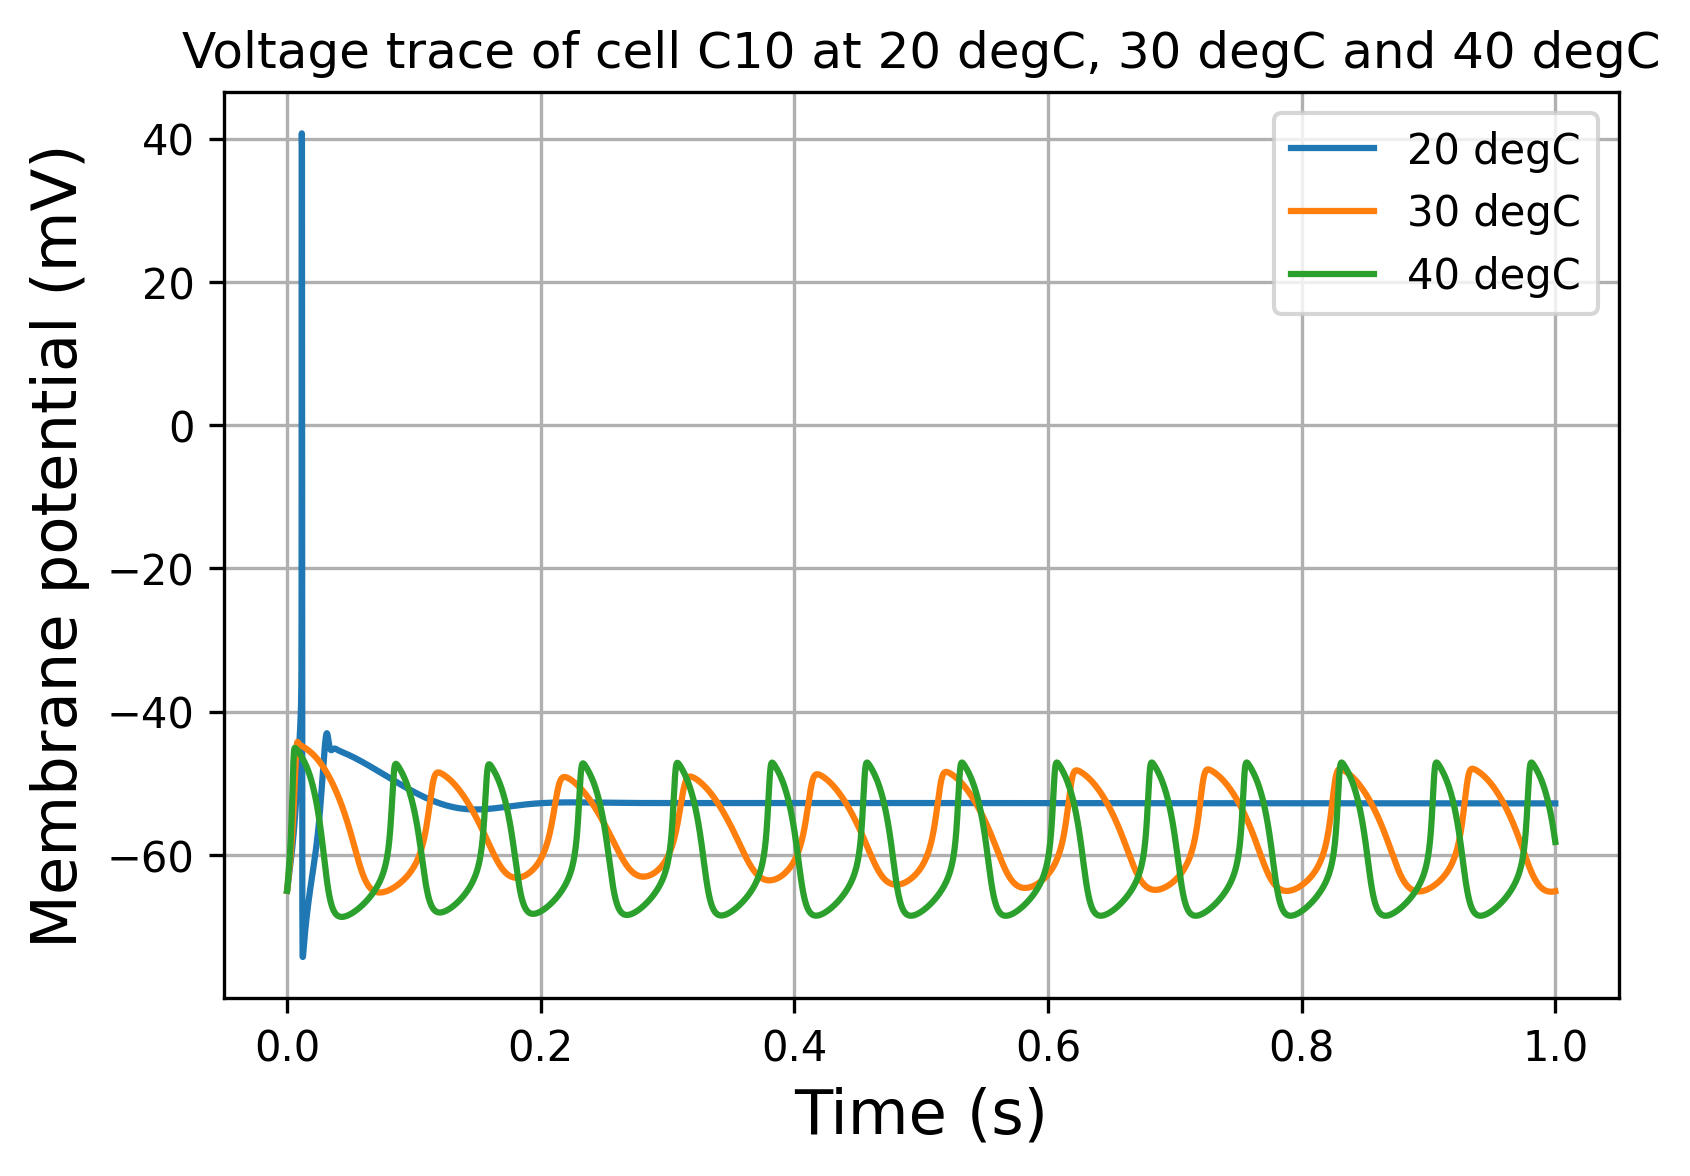


----------------------------------------------------------------------

Plotted cell: C11A


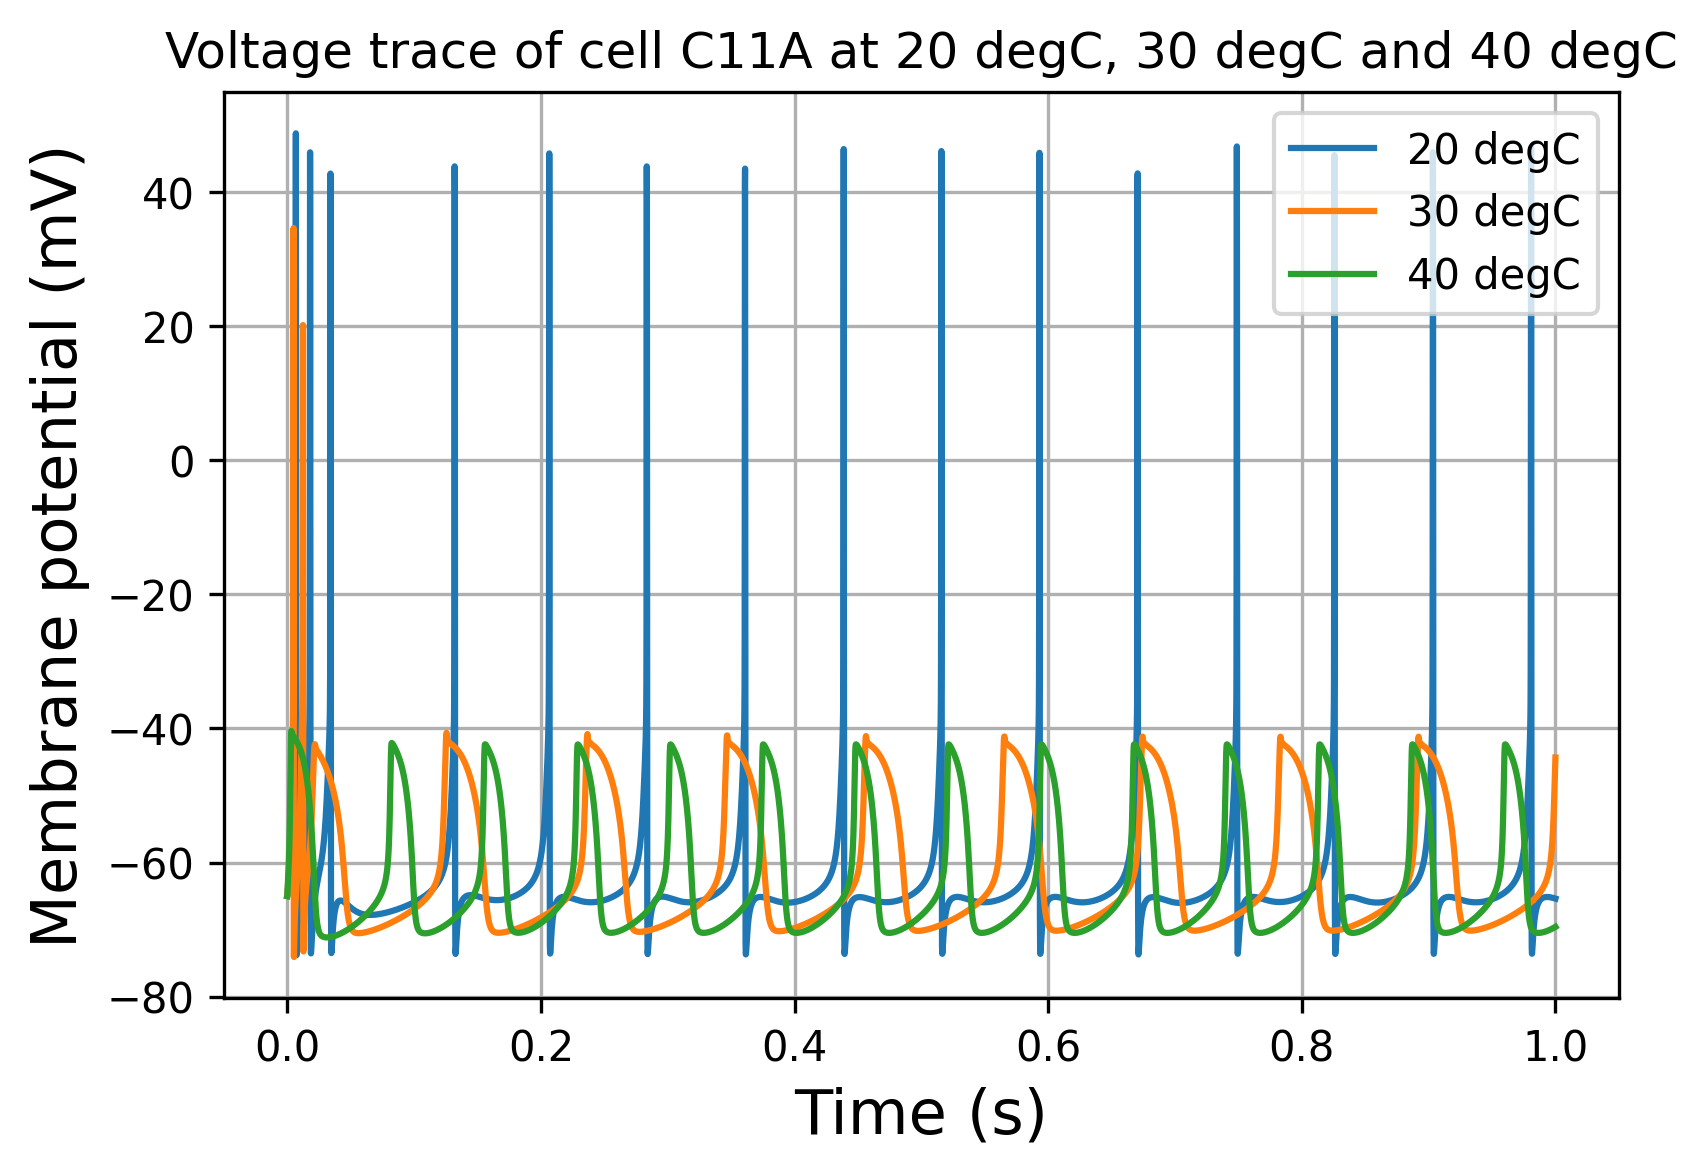


----------------------------------------------------------------------



In [3]:
# Plot every cell apart (I could make a 'plot every temperature apart')

import matplotlib
import matplotlib.pyplot as plt

def correct_data(t,toplot,tP):
    if tP:
        return [t,toplot]
    else:
        return[t[2000:],toplot[2000:]]

transientPlotting = True

for cellName in outputs:
    print(f"Plotted cell: {cellName}")
    output_dict = outputs[cellName]
    
    fig = plt.figure()
    ax = plt.axes()
    ax.set_xlabel('Time (s)', fontsize=15)
    ax.set_ylabel('Membrane potential (mV)', fontsize=15)
    ax.grid(True)

    plotting_AV = False
    AVs = []
    caConc_plotting = False
    cas = []
    for key in output_dict:
        if key == 't':
            # no need to plot sim time against sim time
            continue
        elif key.__contains__('v.'):
            toplot = [x*1000 for x in output_dict[key]]
            newt,toplot = correct_data(t,toplot,transientPlotting)
            ax.plot(newt, toplot, label=""+key)
        elif key.__contains__('caConc.'):
            caConc_plotting = True
            cas.append(key)
        else:
            plotting_AV = True
            AVs.append((key))

    plt.legend(['20 degC','30 degC','40 degC'],loc='upper right')
    ax.set_title(f"Voltage trace of cell {cellName} at 20 degC, 30 degC and 40 degC")
    fig.set_dpi(300.0)
    plt.show()
    
    if caConc_plotting == True:
        plt.xlabel('Time (s)')
        plt.ylabel('Calcium concentration ()')
        plt.grid(True)
        
        for cc in cas:
            toplot = output_dict[cc]
            newt,toplot = correct_data(t,toplot,transientPlotting)
            labl = cc.split('/')[-1]
            plt.plot(newt,toplot,label=""+labl)
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
        plt.title("Calcium concentrations")
        plt.show()
    
    if plotting_AV == True:
        for ttt in temp_range:
            plt.xlabel('Time (s)')
            plt.ylabel('Activation quotient')
            plt.grid(True)

            for av in AVs:
                if not av.__contains__(str(ttt)):
                    continue
                toplot = output_dict[av]
                newt,toplot = correct_data(t,toplot,transientPlotting)
                labl = av.split('/')[-2]+'/'+av.split('/')[-1]
                plt.plot(newt,toplot,label=""+labl)
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0))
            plt.title(f"Activation variables at: {ttt}degC")
            plt.show()
        
    print("\n----------------------------------------------------------------------\n")


Plotted cell: C10
pop/0/C10/0/v.20.0degC
pop/0/C10/0/v.20.1degC
pop/0/C10/0/v.20.2degC
pop/0/C10/0/v.20.3degC
pop/0/C10/0/v.20.4degC
pop/0/C10/0/v.20.5degC
pop/0/C10/0/v.20.6degC
pop/0/C10/0/v.20.7degC
pop/0/C10/0/v.20.8degC
pop/0/C10/0/v.20.9degC
pop/0/C10/0/v.21.0degC
pop/0/C10/0/v.21.1degC
pop/0/C10/0/v.21.2degC
pop/0/C10/0/v.21.3degC
pop/0/C10/0/v.21.4degC
pop/0/C10/0/v.21.5degC
pop/0/C10/0/v.21.6degC
pop/0/C10/0/v.21.7degC
pop/0/C10/0/v.21.8degC
pop/0/C10/0/v.21.9degC
pop/0/C10/0/v.22.0degC
pop/0/C10/0/v.22.1degC
pop/0/C10/0/v.22.2degC
pop/0/C10/0/v.22.3degC
pop/0/C10/0/v.22.4degC
pop/0/C10/0/v.22.5degC
pop/0/C10/0/v.22.6degC
pop/0/C10/0/v.22.7degC
pop/0/C10/0/v.22.8degC
pop/0/C10/0/v.22.9degC
pop/0/C10/0/v.23.0degC
pop/0/C10/0/v.23.1degC
pop/0/C10/0/v.23.2degC
pop/0/C10/0/v.23.3degC
pop/0/C10/0/v.23.4degC
pop/0/C10/0/v.23.5degC
pop/0/C10/0/v.23.6degC
pop/0/C10/0/v.23.7degC
pop/0/C10/0/v.23.8degC
pop/0/C10/0/v.23.9degC
pop/0/C10/0/v.24.0degC
pop/0/C10/0/v.24.1degC
pop/0/C10/0/v.24

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 432x288 -pix_fmt rgba -r 20 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y TempAnimation_C10_20to40_step0.1_longlong.mp4



----------------------------------------------------------------------



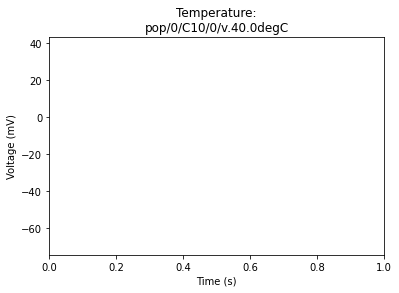

In [11]:
# Animate above plots into animations over Temperature!

from matplotlib.animation import FuncAnimation

def init():
    plotjeh.set_data([],[])
    ax.set_xlim([0,t[-1]])
    ax.set_ylim([minx*1000,maxx*1000])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Voltage (mV)")
    return plotjeh,
    

def animation_func(tempnum):
    #print(t)
    temp = round(temp_range[tempnum],2)
    # print(temp)
    key = "pop/0/"+cellName+"/0/v."+str(temp)+'degC'
    output = output_dict[key]
    toplot = [x*1000 for x in output]
    ax.set_title("Temperature:\n"+key)
    plotjeh.set_data(np.array(t),np.array(toplot))
    return plotjeh,

plotAll = True
plotOne = 'C21B'
# print(temp_range)

if plotAll:
    for cellName in outputs:
        print(f"Plotted cell: {cellName}")
        output_dict = outputs[cellName]
        tpresent = False
        maxx = -99999
        minx = 99999
        for key in output_dict:
            print(key)
            if key == 't':
                tpresent = True
            else:
                if key.__contains__("/v"):
                    if max(output_dict[key]) > maxx:
                        maxx = max(output_dict[key])
                    if min(output_dict[key]) < minx:
                        minx = min(output_dict[key])
        if maxx > 0.15:
            maxx = 0.15
        if minx < -0.15:
            minx = 0.15
        if tpresent:
            del output_dict['t']
        
        fig = plt.figure()
        ax = plt.axes()
        plotjeh, = ax.plot([],[],lw=2)
        anim = FuncAnimation(fig,animation_func,frames=int(len(output_dict)/len(quantities)),interval=100,init_func=init)
        # plt.show()
        anim.save(f"TempAnimation_{cellName}_{start}to{stop}_step{step}_longlong.mp4",writer='ffmpeg', fps=20)
        print("\n----------------------------------------------------------------------\n")
else:
    print(f"Plotted cell: {plotOne}")
    output_dict = outputs[plotOne]
    tpresent = False
    maxx = -99999
    minx = 99999
    for key in output_dict:
        if key == 't':
            tpresent = True
        else:
            if max(output_dict[key]) > maxx:
                maxx = max(output_dict[key])
            if min(output_dict[key]) < minx:
                minx = min(output_dict[key])
    if tpresent:
        del output_dict['t']
    
    fig = plt.figure()
    ax = plt.axes()
    plotjeh, = ax.plot([],[],lw=2)
    
    anim = FuncAnimation(fig,animation_func,frames=int(len(output_dict)/len(quantities)),interval=100,init_func=init)
    #plt.show()
    anim.save(f"TempAnimation_{cellName}_{start}to{stop}_step{step}_TEST.mp4",writer='ffmpeg', fps=30)
    print("\n----------------------------------------------------------------------\n")

## Code to plot one cell at specific temperatures:

Note that this code requires you to first run the simulation above, since this code will use the csv files produced by that script.

In [ ]:
cellName = "C11A"

temp_ran = "20to40_step0.1"
folder = "" # Leave empty if in the same folder

temps_toplot = ["37.0degC"]
variables_toplot = ['v','caConc','m','h','n','k','l']

pulse = True

if folder != '':
    filestring = f"{folder}/{cellName}_0_{temp_ran}_"
else:
    filestring = f"{cellName}_0_{temp_ran}_"
    
if pulse:
    pepe = "pulse"
else:
    pepe = "nopulse"

if 'v' in variables_toplot:
    vdatfile = filestring + f"v_{pepe}.csv"
    vDat = pd.read_csv(vdatfile,index_col=0)
    print("Imported vDat")
    vDatT = pd.DataFrame.transpose(vDat)
    print("Transposed vDat")
    for TT in temps_toplot:
        plt.plot(vDatT[TT])
    print("Plotted all temps")
    plt.xlabel("Time")
    plt.ylabel("Voltage")
    plt.title("Voltage traces")
    print("Trying to show:")
    plt.show()


## Frequency analysis;

I'm going to analyse frequency here

Cell: C10
Temp: pop/0/C10/0/v.32degC
Freq: 0.010379425671779494
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.33degC
Freq: 0.010701545778834719
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.34degC
Freq: 0.011040235525024535
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.35degC
Freq: 0.011381743683132255
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.36degC
Freq: 0.011721802552748111
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.37degC
Freq: 0.012111425111021397
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.38degC
Freq: 0.012517211165352359
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.39degC
Freq: 0.012943308309603937
--------------------------------------------------------
Cell: C10
Temp: pop/0/C10/0/v.40

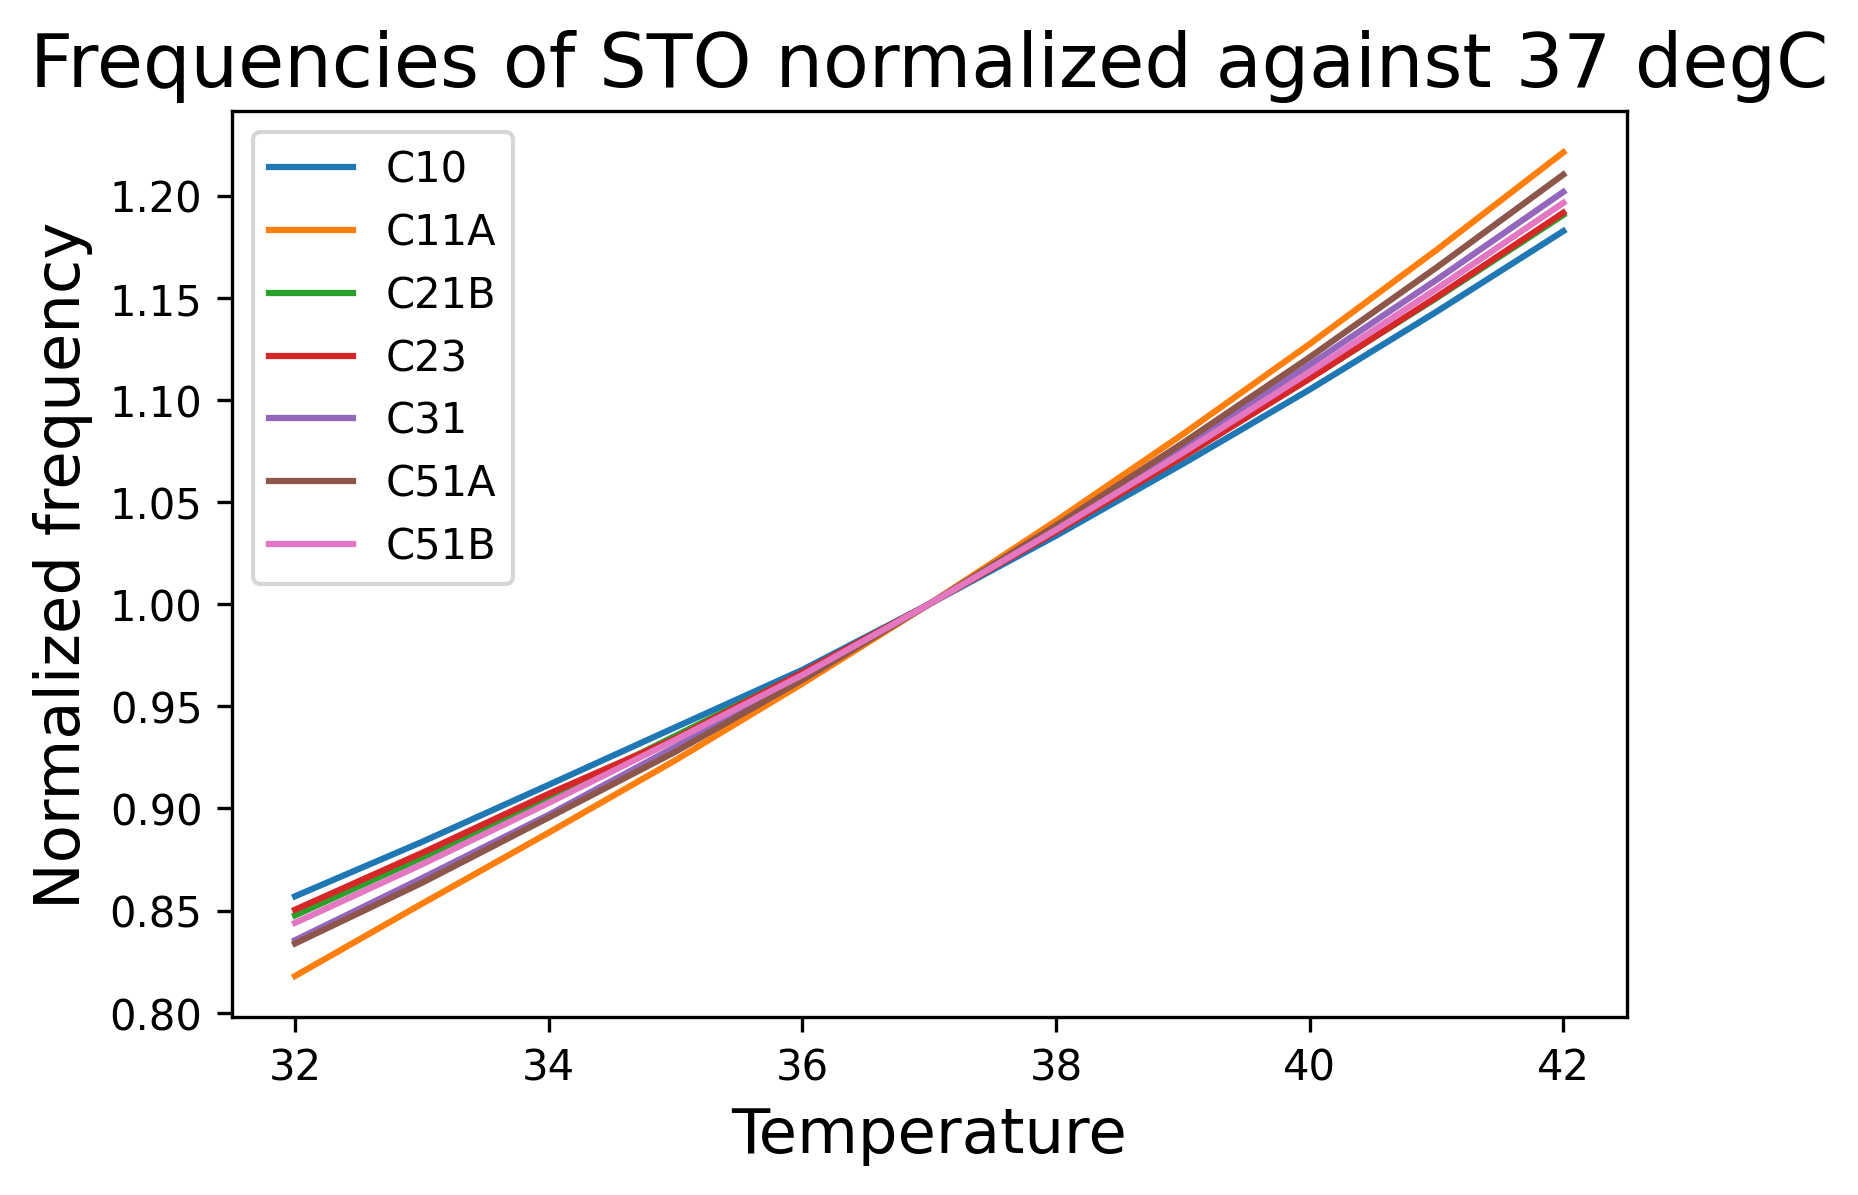

In [6]:
from scipy import signal as sg

def metrics(x, dt=0.1):
    peaks, props = sg.find_peaks(x)
    low, lprops = sg.find_peaks(-x)
    if len(peaks) > 1 and len(low) > 0:
        diifs = np.diff(peaks*dt)
        sumsum = 0
        entries = 0
        for dd in diifs:
            if dd > 25:
                sumsum += dd
                entries += 1
            else:
                sumsum += dd
        period = sumsum/entries
        H = x[peaks].mean()
        L = x[low].mean()
        y = x[peaks[0]:peaks[-1]]
    else:
        H = x.max()
        L = x.min()
        period = 0
        y = x
    F = 1 / period if period > 0 else 0
    A = H - L
    M = (H + L) / 2
    S = (y - M).mean() / abs(y - M).mean()
    return F, A, M, S

freqs = {}
freqsnorm = {}
cells = []

fig = plt.figure()
ax = plt.axes()

for cell in outputs:
    outout = outputs[cell]
    freqscell = {}
    freqscellnorm = {}
    toplot = []
    temps = []
    for temp in outout:
        temps.append(temp)
        F,A,M,S = metrics(np.array(outout[temp][1000:]))
        print(f"Cell: {cell}\nTemp: {temp}\nFreq: {F}\n--------------------------------------------------------")
        freqscell[temp] = F
    if freqscell[f'pop/0/{cell}/0/v.37degC'] != 0:
        cells.append(cell)
        for temp in freqscell:
            freqscellnorm[temp] = freqscell[temp]/freqscell[f'pop/0/{cell}/0/v.37degC']
            toplot.append(freqscellnorm[temp])
        freqs[cell] = freqscell
        freqsnorm[cell] = freqscellnorm

        ax.plot(temp_range,toplot)
        
        
    else:
        print(f"Cell {cell} has no normalized frequency, as the cell does not oscillate")
    
    #print("\n---------------------------------------------------\n")

fig.set_dpi(300.0)
ax.set_xlabel("Temperature", fontsize=15)
ax.set_ylabel("Normalized frequency", fontsize=15)
ax.legend(cells)
ax.set_title("Frequencies of STO normalized against 37 degC", fontsize=18)
plt.show()
    

9001 9001


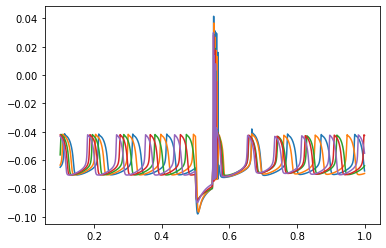

In [32]:
#print(outputs['C11A']['pop/0/C11A/0/v.32degC'][1000:])
print(len(t[1000:]),len(outputs['C11A']['pop/0/C11A/0/v.32degC'][1000:]))

plt.plot(t[1000:],outputs['C11A']['pop/0/C11A/0/v.32degC'][1000:])
plt.plot(t[1000:],outputs['C11A']['pop/0/C11A/0/v.33degC'][1000:])
plt.plot(t[1000:],outputs['C11A']['pop/0/C11A/0/v.34degC'][1000:])
plt.plot(t[1000:],outputs['C11A']['pop/0/C11A/0/v.35degC'][1000:])
plt.plot(t[1000:],outputs['C11A']['pop/0/C11A/0/v.36degC'][1000:])

## Code to write channel NML files with variable maximal conductance parameters  
Has to be integrated with the for loop at the beginning of this notebook.

In [ ]:
#for conductance in conductance_range:
#    output_dict = {}
    
#    nml_doc = nml.NeuroMLDocument(id="cal")

#    channel = nml.IonChannel(id="cal", type="ionChannelHH", conductance=str(conductance)+"pS", species="ca")
#    nml_doc.ion_channel.append(channel)
    
#    scaling = nml.Q10ConductanceScaling(q10_factor="1.6", experimental_temp="20.0 degC")
#    channel.q10_conductance_scalings.append(scaling)
    
#    q10s = nml.Q10Settings(type="q10ExpTemp", q10_factor="3", experimental_temp="20.0degC")
#    ss1 = nml.HHVariable(type="HHSigmoidVariable", rate="1", midpoint="-61mV", scale="4.2mV")
#    timeco1 = nml.HHTime(type="fixedTimeCourse", tau="1 ms")
    
#    gate1 = nml.GateHHTauInf(id="k", instances="3", q10_settings=q10s, time_course=timeco1, steady_state=ss1)
#    channel.gate_hh_tau_infs.append(gate1)
        
#    ss2 = nml.HHVariable(type="HHSigmoidVariable", rate="1", midpoint="-85.5mV", scale="-8.5mV")
#    timeco2 = nml.HHTime(type="CaL_tau", tau="3 ms", midpoint="-40mV", scale="-33mV")
   
#    gate2 = nml.GateHHTauInf(id="l", instances="1", q10_settings=q10s, time_course=timeco2, steady_state=ss2)
#    channel.gate_hh_tau_infs.append(gate2)
    
#    comp = nml.ComponentType(name="CaL_tau", extends="baseVoltageDepTime")
#    nml_doc.ComponentType.append(comp)
    
#    const1 = nml.Constant(name="TIME_SCALE", dimension="time", value="1ms")
#    const2 = nml.Constant(name="VOLT_SCALE", dimension="voltage", value="1mV")
#    dynam = nml.Dynamics()
#    var1 = nml.DerivedVariable(name="V", dimension="none", value="v / VOLT_SCALE")
#    var2 = nml.DerivedVariable(name="t", exposure="t", value="TIME_SCALE*((20 * exp((V + 160) / 30) / (1 + exp((V + 84) / 7.3))) + 35)", dimension = "time")
    
#    comp.Constant.append(const1)
#    comp.Constant.append(const2)
#    comp.Dynamics.append(dynam)
#    dynam.DerivedVariable.append(var1)
#    dynam.DerivedVariable.append(var2)

#    nml_file = "cal.channel.nml"
#    writers.NeuroMLWriter.write(nml_doc, nml_file)

In [ ]:
def flatten(current, key, result):
    if isinstance(current, dict):
        for k in current:
            new_key = "{0}.{1}".format(key, k) if len(key) > 0 else k
            flatten(current[k], new_key, result)
    else:
        result[key] = current
    return result

In [ ]:
#Old code for saving flattened dict

#for key in output_dict_nested:
#    if 't' in output_dict_nested[key]:
#        t = output_dict_nested[key].pop('t')

#if 't' in output_dict:
#    t = output_dict.pop('t')

#output_dict_flat = flatten(output_dict_nested, '', {})
#print(output_dict_flat.keys())

#df = pd.DataFrame(output_dict_flat, index = t)
df = pd.DataFrame(output_dict, index = t)
df = pd.DataFrame.transpose(df)
df.to_csv('output.csv')

In [425]:
%tb

SystemExit: -1